# Методы одномерного поиска

In [264]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

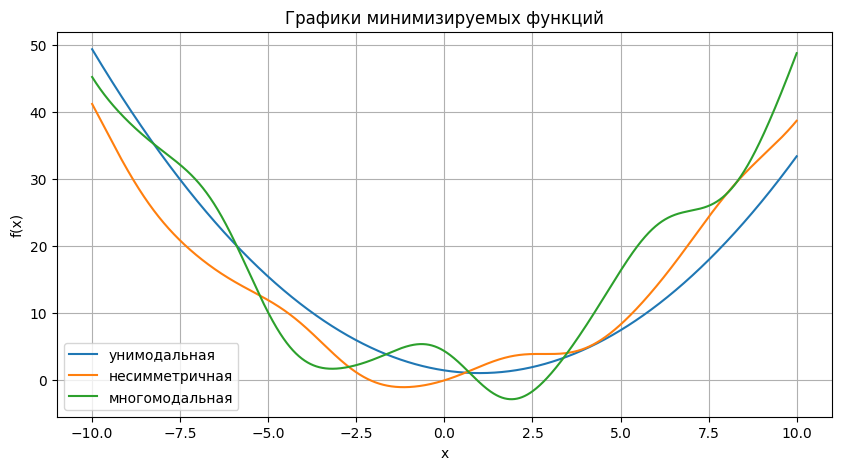

In [265]:
def f_unimod(x):
    return 0.4 * (x-1)**2 + 1
def f_nonsym(x):
    return 0.4 * x**2 + 2*np.sin(x) + 0.2*np.cos(2 * x + 2)
    #return 1e-6 * (x-3.5)**8
def f_mulmod(x):
    return 0.5 * x**2 + 5*np.sin(x-4) + 0.5*np.cos(2 * x)
    #return 0.5 * x**2 + 5*np.sin(x-4) + 5*np.cos(2 * x) + 10*np.cos(3 * x)

x_min = -10.0
x_max = 10.0
N = 10000
x = np.linspace(x_min, x_max, N)

G_plot = np.empty((3,), dtype='object')

G_plot[0] = f_unimod(x)
G_plot[1] = f_nonsym(x)
G_plot[2] = f_mulmod(x)

labels = ['унимодальная', 'несимметричная', 'многомодальная']
plt.figure(figsize=(10,5))
for lbl, G in zip(labels, G_plot):
    plt.plot(x, G, label=lbl)
plt.legend()
plt.title('Графики минимизируемых функций')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.grid(True)
plt.savefig('functions.png', bbox_inches='tight')
plt.show()

In [266]:
max_iter = 200

## Метод дихотомии

In [267]:
def dihotom(f, x_min, x_max, max_iter, eps):
    x_l = x_min
    x_r = x_max
    
    x_low = []
    x_high = []
    x_low.append(x_l)
    x_high.append(x_r)
    
    # Function compute counter.
    counter = 0
    for idx in range(max_iter):
        x_center = (x_l + x_r)/2
        x_center_l = x_center - eps/2.01
        x_center_r = x_center + eps/2.01
        if f(x_center_l) > f(x_center_r):
            x_l = x_center_l
        else:
            x_r = x_center_r
        
        # Function is computed twice.
        counter += 2
        
        x_low.append(x_l)
        x_high.append(x_r)
        
        if (x_r - x_l) < eps:
            return (x_r + x_l)/2, idx, counter, (x_low, x_high)
    print('Solution has not been found (')

## Метод золотого сечения

In [268]:
def golden(f, x_min, x_max, max_iter, eps):
    
    # Constant.
    phi = (1 + np.sqrt(5)) / 2
    # Initial step.
    x_l = x_min
    x_r = x_max
    delta = (x_r - x_l)/phi
    x_center_l = x_r - delta
    x_center_r = x_l + delta
    f_l = f(x_center_l)
    f_r = f(x_center_r)
    
    x_low = []
    x_high = []
    x_low.append(x_l)
    x_high.append(x_r)
    # Function compute counter.
    counter = 2
    
    for idx in range(max_iter):
        if f_l > f_r:
            f_l = f_r
            x_l = x_center_l
            delta = (x_r - x_l)/phi
            x_center_l = x_center_r
            x_center_r = x_l + delta
            f_r = f(x_center_r)
        else:
            f_r = f_l
            x_r = x_center_r
            delta = (x_r - x_l)/phi
            x_center_r = x_center_l
            x_center_l = x_r - delta
            f_l = f(x_center_l)
        
        x_low.append(x_l)
        x_high.append(x_r)
        
        counter += 1
        
        if (x_r - x_l) < eps:
            return (x_r + x_l)/2, idx, counter, (x_low, x_high)
    print('Solution has not been found (')

## Метод Фибоначи

### Генератор последовательности Фибоначи

In [269]:
def generate_fib_seq(K):
    seq = []
    seq.append(1) # F(0)=1
    seq.append(1) # F(1)=1
    for _ in range(K-2):
        seq.append(seq[-1] + seq[-2])
    return seq

Fib = generate_fib_seq(20)
print(Fib)
print(Fib[10]/Fib[12])
print(Fib[11]/Fib[12])

[1, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377, 610, 987, 1597, 2584, 4181, 6765]
0.38197424892703863
0.6180257510729614


In [270]:
def fibonacci(f, x_min, x_max, max_iter, eps):
    # Estimate number of iterations.
    K = int(abs(x_max - x_min) / eps + 0.5)
    
    # Generate K Fibonacci numbers.
    Fib = generate_fib_seq(K)
    
    # Initial step.
    x_l = x_min
    x_r = x_max
    delta = Fib[-2]/Fib[-1] * (x_r - x_l)
    x_center_l = x_l + delta
    x_center_r = x_r - delta
    f_l = f(x_center_l)
    f_r = f(x_center_r)
    
    x_low = []
    x_high = []
    x_low.append(x_l)
    x_high.append(x_r)
    # Function compute counter.
    counter = 2
    
    for idx in range(max_iter):
        if f_l > f_r:
            f_l = f_r
            x_l = x_center_l
            delta = Fib[-2-(idx+1)]/Fib[-1-(idx+1)] * (x_r - x_l)
            x_center_l = x_center_r
            x_center_r = x_r - delta
            f_r = f(x_center_r)
        else:
            f_r = f_l
            x_r = x_center_r
            delta = Fib[-2-(idx+1)]/Fib[-1-(idx+1)] * (x_r - x_l)
            x_center_r = x_center_l
            x_center_l = x_l + delta
            f_l = f(x_center_l)
        
        x_low.append(x_l)
        x_high.append(x_r)
        
        counter += 1
        
        if (x_center_r - x_center_l) < eps:
            return ((x_center_r + x_center_l))/2, idx, counter, (x_low, x_high)
    print('Solution has not been found (')

## Метод парабол

Необходимо определить значения коэффициентов $a$, $b$, $c$ системы уравнений

$\left\{
\begin{aligned}
\bold{a} x_1^2 + \bold{b} x_1 + \bold{c} &= f(x_1), \\
\bold{a} x_2^2 + \bold{b} x_2 + \bold{c} &= f(x_2), \\
\bold{a} x_3^2 + \bold{b} x_3 + \bold{c} &= f(x_3)
\end{aligned}
\right.$

С этой целью обозначим

$F = \begin{bmatrix}
f(x_1) \\
f(x_2) \\
f(x_3)
\end{bmatrix}$,

$P = \begin{bmatrix}
a \\
b \\
c
\end{bmatrix}$,

$M_{sys} = \begin{bmatrix}
x_1^2 & x_1 & 1 \\
x_2^2 & x_2 & 1 \\
x_3^2 & x_3 & 1
\end{bmatrix}$.

Тогда, исходная система уравнений принимает вид

${M_{sys} \cdot P = F}$,
и ее решение:
${P = M_{sys}^{-1} F}$.

In [281]:
def parabol(f, x_min, x_max, max_iter, eps):
    
    x_low = []
    x_high = []
    x_low.append(x_min)
    x_high.append(x_max)
    
    # Function compute counter.
    counter = 3
    
    x_arr = np.array([x_min + eps, (x_max + x_min)/2, x_max - eps])
    F = np.matrix(f(x_arr)).T
    
    M_sys = np.matrix(np.ones((len(x_arr),len(x_arr))))
    for idx, x in enumerate(x_arr):
        M_sys[idx,0] = x**2
        M_sys[idx,1] = x
    
    for idx in range(max_iter):
        # Sort function values (ascending).
        index_rise = F.A[:,0].argsort()
        
        [a, b, _] = np.linalg.inv(M_sys)*F

        if np.abs(a[0,0] > 0):
            v = -b[0,0]/(2*a[0,0])
            f_v = f(v)
            counter += 1
        else:
            # Return x-value [column=1], corresponding to the lowest function value [row=0].
            return M_sys[index_rise][0,1], idx, counter, (x_low, x_high)
        
        F_rise = F[index_rise]
        #if f_v < F_rise[-1]:
        F = F_rise.copy()
        F[-1] = f_v.copy()
        M_sys = M_sys[index_rise].copy()
        M_sys[-1,0] = v**2
        M_sys[-1,1] = v.copy()
        #else:
        #    return v, idx
        
        x_sorted = M_sys[M_sys.A[:,1].argsort()][:,1]
        
        x_low.append(x_sorted[0].tolist()[0][0])
        x_high.append(x_sorted[2].tolist()[0][0])
        
        if (x_sorted[2]-x_sorted[0]) < eps:
            return (x_sorted[1])[0,0], idx+1, counter, (x_low, x_high)
    print('Solution has not been found (')

## Комбинированный метод Брента

In [282]:
def brent(f, x_min, x_max, max_iter, eps):
    # Constant.
    phi = (1 + np.sqrt(5)) / 2
    # Flag means the previous step was computed by the Golden Section.
    golden_sect_flag = False

    x_arr = np.array([x_min + eps, (x_max + x_min)/2, x_max - eps])
    F = np.matrix(f(x_arr)).T
    
    M_sys = np.matrix(np.ones((len(x_arr),len(x_arr))))
    for idx, x in enumerate(x_arr):
        M_sys[idx,0] = x**2
        M_sys[idx,1] = x
    
    x_star = x_arr[1]
    x_star_prev = x_arr[1]

    for idx in range(max_iter):
        # Sort function values (ascending).
        index_rise = F.A[:,0].argsort()
        
        [a, b, _] = np.linalg.inv(M_sys)*F

        if np.abs(a[0,0] > 0):
            v = -b[0,0]/(2*a[0,0])
            f_v = f(v)
        else:
            # Return x-value [column=1], corresponding to the lowest function value [row=0].
            return M_sys[index_rise][0,1], idx, counter, (x_low, x_high)
        
        F_rise = F[index_rise]
        if f_v < F_rise[-1]:
            F = F_rise.copy()
            F[-1] = f_v.copy()
            M_sys = M_sys[index_rise].copy()
            M_sys[-1,0] = v**2
            M_sys[-1,1] = v.copy()
            if np.abs(v - x_star) > np.abs(x_star - x_star_prev)/2:
                x_star_prev = x_star.copy()
                x_star = v.copy()
                golden_sect_flag = False
            else:
                print('golden2')
                if not golden_sect_flag:
                    # Sort x-values (ascending).
                    [x_l, _, x_r] = M_sys[M_sys[:,1].A[:,0].argsort()][:,1]
                    x_l = x_l[0,0]
                    x_r = x_r[0,0]
                    
                    delta = (x_r - x_l)/phi
                    x_center_l = x_r - delta
                    x_center_r = x_l + delta
                    f_l = f(x_center_l)
                    f_r = f(x_center_r)
                    
                    golden_sect_flag = True
                if f_l > f_r:
                    M_sys[0,0] = x_center_l**2
                    M_sys[0,1] = x_center_l
                    F[0] = f_l
                    M_sys[1,0] = x_center_r**2
                    M_sys[1,1] = x_center_r
                    F[1] = f_r
                    
                    f_l = f_r
                    x_l = x_center_l
                    delta = (x_r - x_l)/phi
                    x_center_l = x_center_r
                    x_center_r = x_l + delta
                    f_r = f(x_center_r)
                    
                    M_sys[2,0] = x_center_r**2
                    M_sys[2,1] = x_center_r
                    F[2] = f_r
                else:
                    M_sys[2,0] = x_center_r**2
                    M_sys[2,1] = x_center_r
                    F[2] = f_r
                    M_sys[1,0] = x_center_l**2
                    M_sys[1,1] = x_center_l
                    F[1] = f_l
                    
                    f_r = f_l
                    x_r = x_center_r
                    delta = (x_r - x_l)/phi
                    x_center_r = x_center_l
                    x_center_l = x_r - delta
                    f_l = f(x_center_l)
                    
                    M_sys[0,0] = x_center_l**2
                    M_sys[0,1] = x_center_l
                    F[0] = f_l
                
                x_star_prev = x_star.copy()
                x_star = M_sys[1,1] 
        else:
            print('golden1')
            if not golden_sect_flag:
                # Sort x-values (ascending).
                [x_l, _, x_r] = M_sys[M_sys[:,1].A[:,0].argsort()][:,1]
                x_l = x_l[0,0]
                x_r = x_r[0,0]
                
                delta = (x_r - x_l)/phi
                x_center_l = x_r - delta
                x_center_r = x_l + delta
                f_l = f(x_center_l)
                f_r = f(x_center_r)
                
                golden_sect_flag = True
            if f_l > f_r:
                M_sys[0,0] = x_center_l**2
                M_sys[0,1] = x_center_l
                F[0] = f_l
                M_sys[1,0] = x_center_r**2
                M_sys[1,1] = x_center_r
                F[1] = f_r
                
                f_l = f_r
                x_l = x_center_l
                delta = (x_r - x_l)/phi
                x_center_l = x_center_r
                x_center_r = x_l + delta
                f_r = f(x_center_r)
                
                M_sys[2,0] = x_center_r**2
                M_sys[2,1] = x_center_r
                F[2] = f_r
            else:
                M_sys[2,0] = x_center_r**2
                M_sys[2,1] = x_center_r
                F[2] = f_r
                M_sys[1,0] = x_center_l**2
                M_sys[1,1] = x_center_l
                F[1] = f_l
                
                f_r = f_l
                x_r = x_center_r
                delta = (x_r - x_l)/phi
                x_center_r = x_center_l
                x_center_l = x_r - delta
                f_l = f(x_center_l)
                
                M_sys[0,0] = x_center_l**2
                M_sys[0,1] = x_center_l
                F[0] = f_l
            
            x_star_prev = x_star.copy()
            x_star = M_sys[1,1]
        x_sorted = M_sys[M_sys.A[:,1].argsort()][:,1]
        
        if (x_sorted[2]-x_sorted[0]) < eps:
            return (x_sorted[1])[0,0], idx+1, counter, (x_low, x_high)
    print('Solution has not been found (')

In [304]:
optim_methods = [dihotom, golden, parabol]#, fibonacci]
N_eps = 8
eps_var = np.logspace(-1,-8, N_eps)

interval_arr = np.empty((len(optim_methods),), dtype='object')
x_optim_arr = np.empty((len(optim_methods),), dtype='object')
iter_counter_arr = np.empty((len(optim_methods),), dtype='object')
func_counter_arr = np.empty((len(optim_methods),), dtype='object')

for mdx, opt_method in enumerate(optim_methods):
    x_optim_list = []
    iter_counter_list = []
    func_counter_list = []
    interval_list = np.empty((len(eps_var),2), dtype='object')
    for idx, eps in enumerate(eps_var):
        x_optim, iter_counter, func_counter, interval = \
            opt_method(f=f_nonsym, x_min=x_min, x_max=x_max, max_iter=max_iter, eps=eps)
        x_optim_list.append(x_optim)
        iter_counter_list.append(iter_counter)
        func_counter_list.append(func_counter)
        interval_list[idx][0] = interval[0]
        interval_list[idx][1] = interval[1]
        
    x_optim_arr[mdx] = x_optim_list
    iter_counter_arr[mdx] = iter_counter_list
    func_counter_arr[mdx] = func_counter_list
    interval_arr[mdx] = interval_list

Преобразуем в таблицы.

In [284]:
method_names = [func.__name__ for func in optim_methods]

x_optim_tbl = eps_var
for col in x_optim_arr:
    x_optim_tbl = np.vstack((x_optim_tbl, col))
x_optim_df = pd.DataFrame(x_optim_tbl.T, columns=['eps'] + method_names)

iter_counter_tbl = eps_var
for col in iter_counter_arr:
    iter_counter_tbl = np.vstack((iter_counter_tbl, col))
iter_counter_df = pd.DataFrame(iter_counter_tbl.T, columns=['eps'] + method_names)
iter_counter_df[method_names] = iter_counter_df[method_names].astype(int)

func_counter_tbl = eps_var
for col in func_counter_arr:
    func_counter_tbl = np.vstack((func_counter_tbl, col))
func_counter_df = pd.DataFrame(func_counter_tbl.T, columns=['eps'] + method_names)
func_counter_df[method_names] = func_counter_df[method_names].astype(int)

In [285]:
print('Таблица оптимальных значений')
display(x_optim_df)

Таблица оптимальных значений


,eps,dihotom,golden,parabol
0,1.000000e-01,-1.157998,-1.152949,-1.158171
1,1.000000e-02,-1.158119,-1.159211,-1.158129
2,1.000000e-03,-1.158135,-1.158045,-1.158134
3,1.000000e-04,-1.158134,-1.158150,-1.158134
4,1.000000e-05,-1.158134,-1.158134,-1.158134
5,1.000000e-06,-1.158134,-1.158134,-1.158134
6,1.000000e-07,-1.158134,-1.158134,-1.158134
7,1.000000e-08,-1.158134,-1.158134,-1.158134


In [286]:
print('Таблица количества итераций')
display(iter_counter_df)

Таблица количества итераций


,eps,dihotom,golden,parabol
0,1.000000e-01,15,11,7
1,1.000000e-02,18,15,8
2,1.000000e-03,21,20,9
3,1.000000e-04,25,25,9
4,1.000000e-05,28,30,10
5,1.000000e-06,31,34,16
6,1.000000e-07,35,39,46
7,1.000000e-08,38,44,173


In [287]:
print('Таблица количества вычислений функции')
display(func_counter_df)

Таблица количества вычислений функции


,eps,dihotom,golden,parabol
0,1.000000e-01,32,14,10
1,1.000000e-02,38,18,11
2,1.000000e-03,44,23,12
3,1.000000e-04,52,28,12
4,1.000000e-05,58,33,13
5,1.000000e-06,64,37,19
6,1.000000e-07,72,42,49
7,1.000000e-08,78,47,176


In [288]:
plot_list = [x_optim_df, iter_counter_df, func_counter_df]
plot_name = ['Минимум функции', 'Количество итераций', 'Количество вычислений функции']

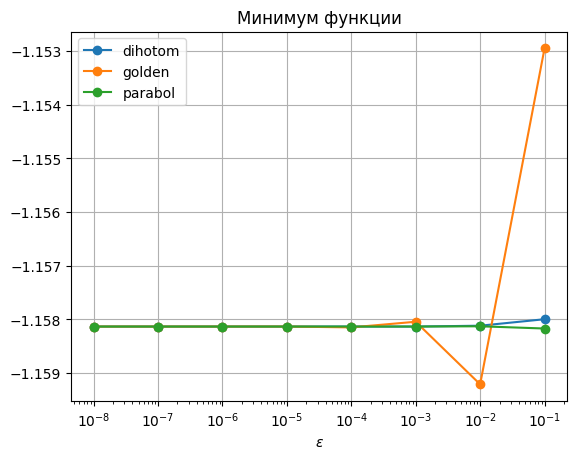

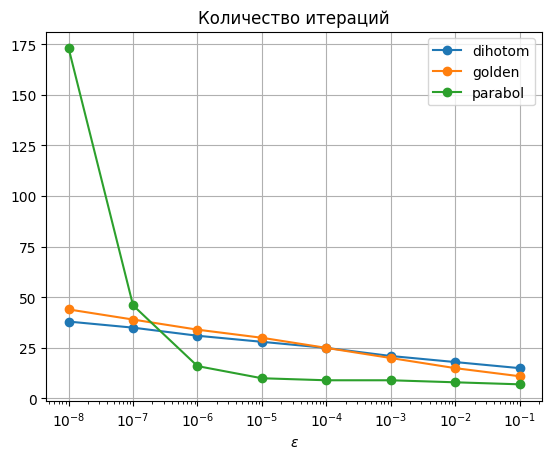

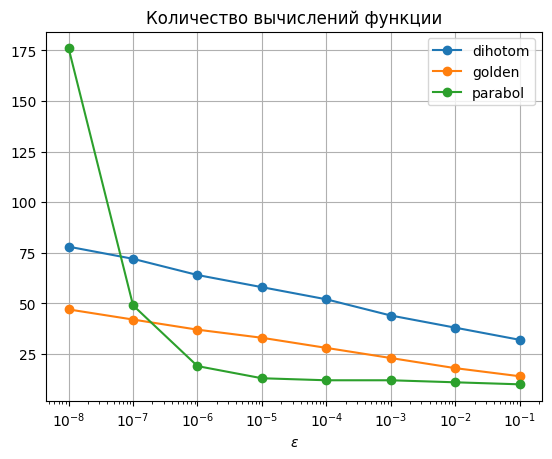

In [303]:
for plt_lst, plt_name in zip(plot_list, plot_name):
    plt.plot(eps_var, plt_lst[method_names], marker='.', markersize=12)
    plt.title(plt_name)
    plt.grid()
    plt.xscale('log')
    plt.xlabel('$\epsilon$')
    plt.legend(method_names)
    plt.show()

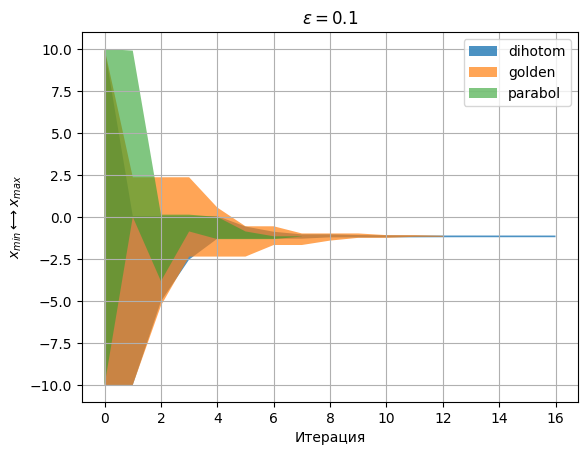

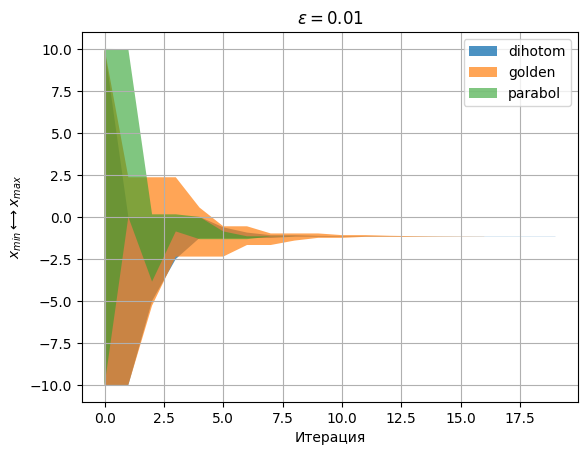

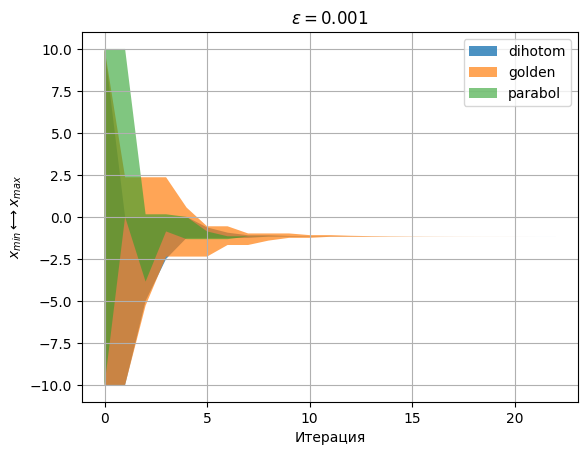

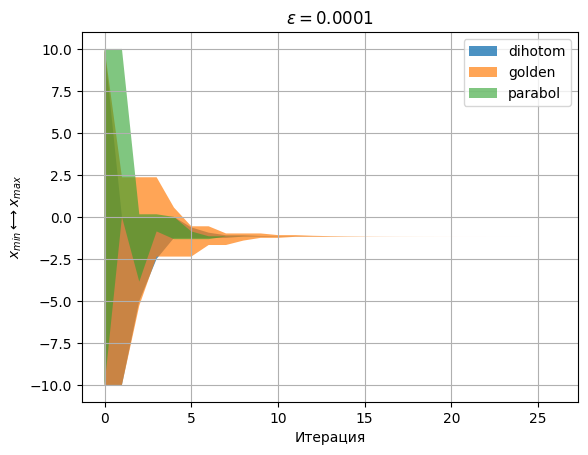

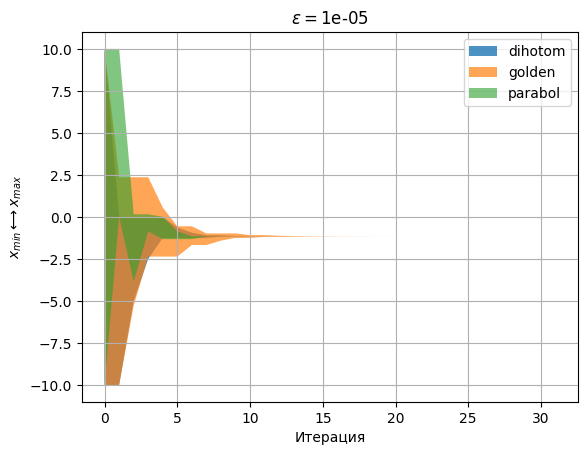

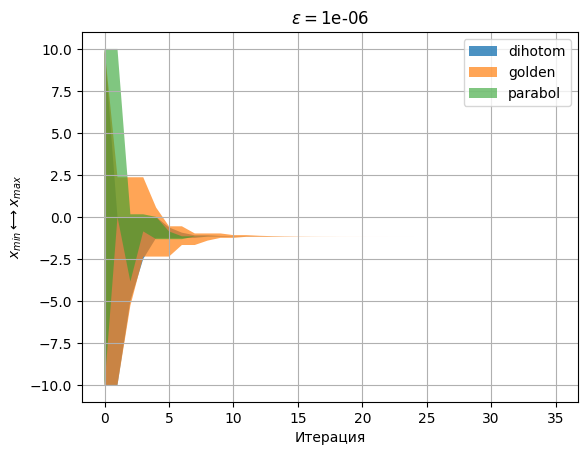

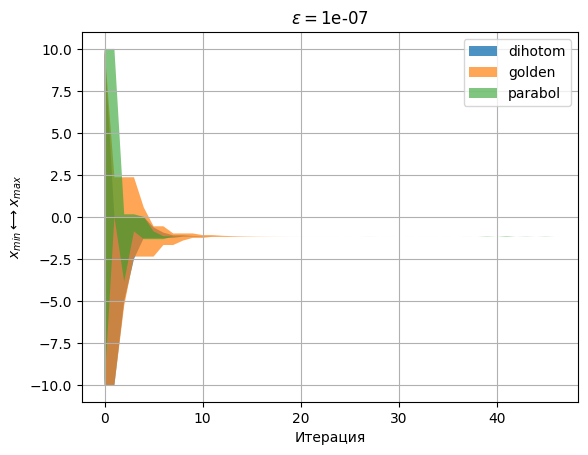

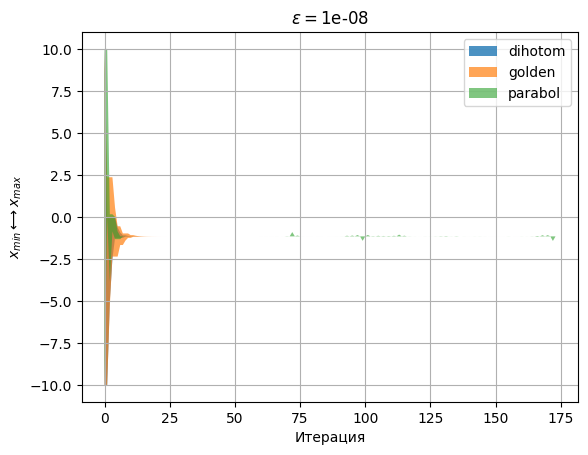

In [302]:
for idx, eps in enumerate(eps_var):
    for mdx, meth_name in enumerate(method_names):
        plt.fill_between(list(range(len(interval_arr[mdx][idx][0]))), interval_arr[mdx][idx][0], interval_arr[mdx][idx][1], alpha=(0.8 - 0.1 * mdx), label=meth_name)
    plt.grid()
    plt.title('$\epsilon =$' + str(eps))
    plt.xlabel('Итерация')
    plt.ylabel('$x_{min} \longleftrightarrow x_{max}$')
    plt.legend()
    plt.show()